# SBSS LLOCV
Annual models with station based spatial splitting for leave location out cross validation

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from scipy.stats import gaussian_kde
import geopandas as gpd
import random
from sklearn.model_selection import KFold
from datetime import datetime
from itertools import combinations
from scipy.special import inv_boxcox

In [2]:
def LLOCV(dataframe, num_folds, station_names, model):
    """
    Function that performs leave location out cross validation on water quality time series data.
    The stations are divided into training and testing sets by referring to the unique station_name column.
    """
   
    kf = KFold(n_splits=num_folds)
    scores = []

    for train_index, test_index in kf.split(station_names):
        
        #print(f"train index: {train_index}")
        #print(f"test index: {test_index}\n")
        station_names_df = pd.DataFrame(station_names, columns=["station_names"])
        train_stations = station_names_df.iloc[train_index,:]["station_names"].values
        test_stations =  station_names_df.iloc[test_index,:]["station_names"].values

        train_df = dataframe[dataframe['station_name'].isin(train_stations)]
        test_df = dataframe[dataframe['station_name'].isin(test_stations)]

        
        # Assume the feature columns are all except 'station_name' and 'target_column'
        X_train = train_df.iloc[:,8:]
        y_train = train_df.iloc[:,1]
        X_test = test_df.iloc[:,8:]
        y_test = test_df.iloc[:,1]
        
        
        model.fit(X_train, y_train)
        
        # Test the model
        y_pred = model.predict(X_test)
        score = mean_squared_error(y_test, y_pred)
        scores.append(score)
        #print(f"Score of this fold = {r2}\n")
    rmse_scores = np.sqrt(scores)
    average_rmse = np.mean(rmse_scores)

    return average_rmse

In [3]:
def split_with_spatial_dist(dataframe, bandwidth, train_ratio, block_size, random_seed = None ):
    """
        Splits the given dataset into training and testing sets, maintaining similar spatial distribution in both sets. 
        Uses a gaussian kernel desnsity estimation technique to calculate probabilty density of monitoring stations' location. 
        Using the probabilty density, assigns weights to stations and uses these weights to split the stations into training and testing sets. 
        Note: depending on the user, the dataframe might be different. Hence certain sections of this function might need to be edited depending on 
        the structure of your dataframe. 
        Author: Karan Mahajan, Technical University of Munich, karanmahajan.chd@gmail.com
    Args:
        dataframe (pandas dataframe): The data file with the station latitude and longitude columns
        bandwith (int): Bandwith in kilometer for the kernel density estimation technique
        train_ratio (float): proportion of data to be included in the training set. Recommended is 0.8 
        block_size (int): the size of individual blocks of density values out of which user wants to sample data for testing and training sets.
        random_seed (int): to ensure that results can be reproduces. If not specified, we'll get a different split everytime the function is run. 

    Returns:
        kde: kernel density estimate, that is fitted using the coordinate data
        sorted_df: dataframe sorted according to the density weights (ascending order). The X data in this dataframe is scaled using standard scaler.
        train_ind: indices from sorted_df that go into training set
        test_ind: indices from sorted_df that go into testing set
        
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    train_ind = []
    test_ind = []
    
    # Set the bandwidth in degrees (approximation: 1 degree latitude ≈ 111 km)
    bandwidth_deg = round(bandwidth / 111, 2)  # Convert 50 km to degrees
    
    # Generate the Gaussian Kernel Density Estimate
    xy = np.vstack([dataframe['lon'], dataframe['lat']])
    kde = gaussian_kde(xy, bw_method=bandwidth_deg)

    # Evaluate KDE only over the station points
    density_weights = kde(np.vstack([dataframe['lon'], dataframe['lat']]))

    test_df = dataframe.copy()

    # Add desnity_weights to the dataframe
    test_df['density_val'] = density_weights

    sorted_df = test_df.sort_values(by='density_val').reset_index(drop=True)

    # Loop through sorted_df in blocks of block_size, and then randomly sample train_ratio*10 samples for training and remaining for testing
    for i in range(0, len(sorted_df),block_size):
        block_indices = list(range(i,min(len(sorted_df), i+block_size)))
        np.random.shuffle(block_indices)
        num_train_block = int(train_ratio*10)
        train_indices_block = block_indices[:num_train_block]
        test_indices_block = block_indices[num_train_block:]

        train_ind.extend(train_indices_block)
        test_ind.extend(test_indices_block)

    np.random.shuffle(train_ind)
    np.random.shuffle(test_ind)


    return kde, sorted_df, train_ind, test_ind


In [4]:
with open("lambda_boxcox", 'rb') as file:
    lambda_boxcox = pickle.load(file)

In [5]:
#encode months as cyclical features

def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [6]:
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
dataframes = {}

for i,month in enumerate(months):
    with open(f"final_df_{month}_new", 'rb') as file:
        final_df_month_new = pickle.load(file)
        final_df_month_new['month'] = i+1 
        final_df_month_new.insert(2,'month',final_df_month_new.pop('month')) # insertion index, name to insert, value to insert. pop deletes the column but also returns its value
        final_df_month_new = encode(final_df_month_new,'month',12)
    dataframes[month] = final_df_month_new

In [7]:
new_dataframes = {}
tmin = {}
tmax = {}
prec_sum = {}
i=1
for month in dataframes.keys():
    new_dataframes[month] = dataframes[month].rename(columns={f"tmin_avg_{i}": "tmin_avg", f"tmax_avg_{i}": "tmax_avg", f"prec_sum_{i}": "prec_sum" })
    i=i+1

In [8]:
merged_dfs = pd.concat(new_dataframes.values()).reset_index(drop = True)

In [9]:
def pearson_corr_coeff(X,y):
    X_bar = np.mean(X)
    y_bar = np.mean(y)
    numr = np.sum((X-X_bar)*(y-y_bar))
    denmr = np.sqrt(np.sum(np.square(X-X_bar)*np.sum(np.square(y-y_bar))))
    r = numr/denmr
    return r

In [10]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(merged_dfs.iloc[:,8:])
scaled_df = pd.DataFrame(scaled_features, index=merged_dfs.index, columns=merged_dfs.columns[8:])
scaled_df = scaled_df.astype('float32')  # Explicitly cast to float32 if needed because the data type might not match

# Replace the original data with the scaled data
merged_dfs_scaled = merged_dfs.copy()
merged_dfs_scaled.iloc[:, 8:] = scaled_df

In [11]:
station_names = merged_dfs_scaled.station_name.unique()
unique_stations_df = merged_dfs_scaled[['station_name', 'lon', 'lat']].drop_duplicates(subset = ["station_name"])
unique_stations_df.reset_index(drop=True, inplace=True)

In [12]:
with open('unique_stations_sbss', 'wb') as file:
        pickle.dump(unique_stations_df, file)

In [13]:
kde, sorted_df, train_ind, test_ind = split_with_spatial_dist(unique_stations_df, 20, 0.8, 10, 42 )  # indices correspond to sorted_df

In [16]:
shapefile_path = r"J:\study_project\geoBoundaries-DEU-ADM1-all\bavaria_outline.shp"
bavaria_polygon = gpd.read_file(shapefile_path)
bavaria_polygon = bavaria_polygon.to_crs('EPSG:4326')

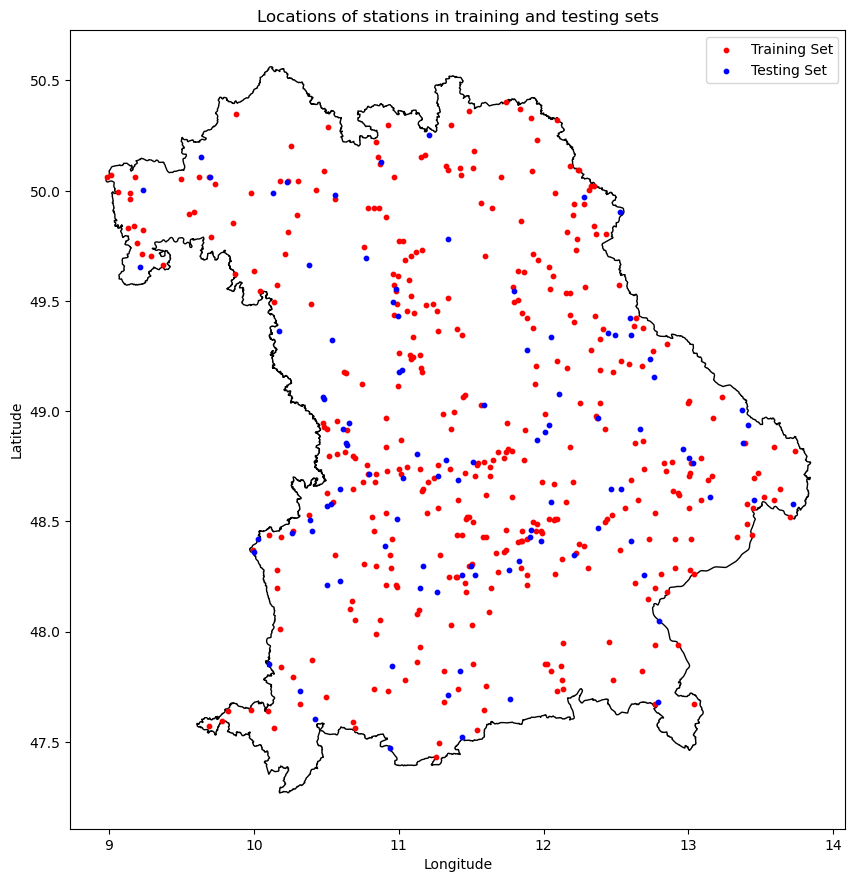

In [17]:
fig, ax = plt.subplots(figsize=(10,12))
bavaria_polygon.plot(ax = ax,color='white', edgecolor='black')
plt.scatter(sorted_df.loc[train_ind,'lon'], sorted_df.loc[train_ind,'lat'], color='red',s=10, label='Training Set' )
plt.scatter(sorted_df.loc[test_ind,'lon'], sorted_df.loc[test_ind,'lat'], color='blue',s=10, label = 'Testing Set' )
plt.title('Locations of stations in training and testing sets')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

In [18]:
station_names_train = list(sorted_df.iloc[train_ind, 0])
station_names_test = list(sorted_df.iloc[test_ind, 0])

In [19]:
train_df = merged_dfs_scaled[merged_dfs_scaled["station_name"].isin(station_names_train)]
test_df = merged_dfs_scaled[merged_dfs_scaled["station_name"].isin(station_names_test)]

In [20]:
train_df_sbss = train_df.sample(frac=1)
test_df_sbss = test_df.sample(frac=1)

In [24]:
test_df_sbss

NO3-N [mg/l]  NO3-N [mg/l] BC  month                 station_name  \
3193      3.808167         1.582373      7            uh Br. westl. Egg   
759       1.034000         0.032710      2           uh Oberschleißheim   
2248      1.243000         0.213932      5        Br. Waldrand Kochheim   
612       7.740500         3.137142      2      Segelflugplatz Burgheim   
1243      8.814000         3.468516      3            uh Appertshausen    
...            ...              ...    ...                          ...   
2391      7.759333         3.159331      5              oh. Bahnbrücke    
2423      6.271500         2.700995      5  Br. Fuerth-Atzenhof oh Mdg.   
5847      4.261714         1.952924     12   WRRL-Stelle uh. Brunnmühle   
2889      5.367500         2.382507      6            oh Zufluss Altach   
712       0.491500        -0.619419      2             Rissbach / Pegel   

     station_number           water_body        lat        lon  slope_avg  \
3193          11132              Erlbach  48.195833  11.145833  -0.713018   
759          105630  Schleißheimer Kanal  48.254167  11.529167  -0.815421   
2248          96513   Schornreuter Kanal  48.704167  11.270833  -0.643530   
612           96508           Leitenbach  48.695833  11.029167  -0.625244   
1243         103258           Moosgraben  48.512500  10.987500  -0.581357   
...             ...                  ...        ...        ...        ...   
2391         103286     Bubesheimer Bach  48.445833  10.262500  -0.742276   
2423          17661            Farrnbach  49.495833  10.962500  -0.606958   
5847           8048            Lauterach  49.279167  11.887500  -0.442381   
2889         135610             Gfällach  48.320833  11.829167  -0.837365   
712          113916              Rißbach  47.520833  11.437500   4.165759   

      elev_avg  ...  soil_avg_06  soil_avg_07  soil_avg_08  soil_avg_09  \
3193 -0.129573  ...    -1.247917     0.682185     0.447038     0.525972   
759  -0.334994  ...    -1.247917    -0.117797    -0.976045     0.525972   
2248 -0.723427  ...    -1.247917     0.148863    -0.795336     0.525972   
612  -0.562825  ...    -1.247917    -0.384458     0.492215     0.525972   
1243 -0.413428  ...    -0.743757    -0.917780     0.695512     0.525972   
...        ...  ...          ...          ...          ...          ...   
2391 -0.484391  ...    -1.247917    -0.384458     0.447038     0.525972   
2423 -0.928848  ...     0.012482    -1.184440     0.582569     0.525972   
5847 -0.357404  ...    -0.239598     0.948846     0.221152    -2.711982   
2889 -0.484391  ...    -2.004156     1.748828    -0.998633     0.424786   
712   3.467160  ...     2.281200     2.015489    -3.234906    -4.533331   

      soil_avg_10  tmin_avg  tmax_avg  prec_sum  month_sin  month_cos  
3193    -0.940345  1.509251  1.330210 -0.345118  -0.706895  -1.224521  
759     -1.139791 -1.287194 -1.175115 -0.343139   1.225449   0.706839  
2248    -0.940345  0.678791  0.774906 -0.317103   0.707679  -1.224521  
612     -1.139791 -1.134661 -1.136373 -0.349256   1.225449   0.706839  
1243    -0.342005 -0.626216 -0.516498 -0.348240   1.414966  -0.000088  
...           ...       ...       ...       ...        ...        ...  
2391    -1.139791  0.627947  0.697422 -0.349750   0.707679  -1.224521  
2423    -0.342005  0.678791  0.826563 -0.343340   0.707679  -1.224521  
5847     2.849141 -1.049920 -1.330083 -0.317336   0.000392   1.413766  
2889    -0.740898  1.170287  1.136500 -0.344161   0.000392  -1.413942  
712      4.245267 -1.660054 -1.342997 -0.331513   1.225449   0.706839  

[1182 rows x 56 columns]

In [98]:
X = merged_dfs_scaled.iloc[:,8:]
y = merged_dfs_scaled.iloc[:,1]

X_train_sbss = train_df_sbss.iloc[:,8:]
X_test_sbss = test_df_sbss.iloc[:,8:]
y_train_sbss = train_df_sbss.iloc[:,1]
y_test_sbss = test_df_sbss.iloc[:,1]

y_train_sbss_og = train_df_sbss.iloc[:,0]
y_test_sbss_og = test_df_sbss.iloc[:,0]

train_indices_sbss = X_train_sbss.index  # indices corresponding to merged_dfs_scale
test_indices_sbss = X_test_sbss.index

In [99]:
# Default model

model_default_merged_sbss = RandomForestRegressor(random_state = 42, n_jobs=45)
model_default_merged_sbss.fit(X_train_sbss, y_train_sbss)
y_pred_default_merged_sbss = model_default_merged_sbss.predict(X_test_sbss)
rmse_model_default_merged_sbss = np.sqrt(mean_squared_error(y_test_sbss_og, inv_boxcox(y_pred_default_merged_sbss, lambda_boxcox)))
r2_model_default_merged_sbss = r2_score(y_test_sbss, y_pred_default_merged_sbss)
r2_model_default_merged_sbss_og = r2_score(y_test_sbss_og, inv_boxcox(y_pred_default_merged_sbss, lambda_boxcox))
r_model_default_merged_sbss = pearson_corr_coeff(y_test_sbss, y_pred_default_merged_sbss)
print('RMSE [mg/L], model = default merged: ',rmse_model_default_merged_sbss)
print('R2, model = default merged: ', r2_model_default_merged_sbss)
print('R2 OG, model = default merged: ', r2_model_default_merged_sbss_og)
print('R, model = default merged: ', r_model_default_merged_sbss)

RMSE [mg/L], model = default merged:  1.4865607728701418
R2, model = default merged:  0.5016193312074861
R2 OG, model = default merged:  0.4751763106032202
R, model = default merged:  0.7402775011894375


In [120]:
y_pred_default_merged_sbss_og = inv_boxcox(y_pred_default_merged_sbss, lambda_boxcox)

In [121]:
# Calculate the goodness of fit for monthly subsets
# extract the datafame for just the test indices
# extract the indices where the month is equal to the given month
# extract the y_test and y_pred values at these indices and compute gof

df_test_sbss = merged_dfs_scaled.iloc[test_indices_sbss,:].reset_index(drop = True)  # Extract all the data in the test set dataframe and reset its index to match the indexy range of y_predict
y_test_reset_ind_sbss_og = y_test_sbss_og.reset_index(drop = True)    # y_test had row indices of the original dataframe. Reset index to match index of y_predict
y_test_reset_ind_sbss = y_test_sbss.reset_index(drop = True)
df_train_sbss = merged_dfs_scaled.iloc[train_indices_sbss,:].reset_index(drop = True)
# save the data in a dictionary. keys are the month names. These dicts will later be used to generate figures.
rmse_Months_default_merged_sbss = {}
r2_Months_default_merged_sbss_og = {}
r2_Months_default_merged_sbss = {}
r_Months_default_merged_sbss = {}
y_pred_Months_default_merged_sbss = {}
y_test_Months_default_merged_sbss = {}

y_pred_Months_default_merged_sbss_og = {}
y_test_Months_default_merged_sbss_og = {}


df_months_test_sbss = {}
df_months_train_sbss = {}

for i, month in enumerate(months):
                         
    df_test_month = df_test_sbss.loc[df_test_sbss['month'] == (i+1),:]   # Extract the data from test set corresponding to the given month
    df_train_month = df_train_sbss.loc[df_train_sbss['month'] == (i+1),:]
    df_test_month_indices = df_test_month.index                # Extract the indices from the test set that correspond to the given month
    # only calculate the error metrics for a subset of the test set. Subset based on the given month. 
    y_test_month_og = y_test_reset_ind_sbss_og[df_test_month_indices]
    y_pred_month_og = y_pred_default_merged_sbss_og[df_test_month_indices]

    y_test_month = y_test_reset_ind_sbss[df_test_month_indices]
    y_pred_month = y_pred_default_merged_sbss[df_test_month_indices]    
    
    
    rmse_month_default_merged = np.sqrt(mean_squared_error(y_test_month_og, y_pred_month_og))
    r2_month_default_merged = r2_score(y_test_month, y_pred_month)
    r2_month_default_merged_og = r2_score(y_test_month_og, y_pred_month_og)
    r_month_default_merged = pearson_corr_coeff(y_test_month, y_pred_month)

    # add data to the dictionaries
    rmse_Months_default_merged_sbss[month] = rmse_month_default_merged
    r2_Months_default_merged_sbss[month] = r2_month_default_merged
    r2_Months_default_merged_sbss_og[month] = r2_month_default_merged_og
    r_Months_default_merged_sbss[month] = r_month_default_merged
    
    y_pred_Months_default_merged_sbss[month] = y_pred_month
    y_test_Months_default_merged_sbss[month] = y_test_month

    y_pred_Months_default_merged_sbss_og[month] = y_pred_month_og
    y_test_Months_default_merged_sbss_og[month] = y_test_month_og
    
    df_months_test_sbss[month] = df_test_month
    df_months_train_sbss[month] = df_train_month
    # print gof metrics for each month
    print(f'RMSE default for {month} = {np.round(rmse_Months_default_merged_sbss[month],5)}')
    print(f'R2 default for {month} = {np.round(r2_Months_default_merged_sbss[month],5)}')
    print(f'R2 OG default for {month} = {np.round(r2_Months_default_merged_sbss_og[month],5)}')
    print(f'R default for {month} = {np.round(r_Months_default_merged_sbss[month], 5)}')
    print('')

RMSE default for jan = 1.46089
R2 default for jan = 0.585
R2 OG default for jan = 0.56604
R default for jan = 0.77748

RMSE default for feb = 1.39499
R2 default for feb = 0.60604
R2 OG default for feb = 0.59126
R default for feb = 0.79005

RMSE default for mar = 1.52911
R2 default for mar = 0.56309
R2 OG default for mar = 0.5276
R default for mar = 0.76999

RMSE default for apr = 1.55285
R2 default for apr = 0.4891
R2 OG default for apr = 0.45958
R default for apr = 0.73159

RMSE default for may = 1.49602
R2 default for may = 0.4371
R2 OG default for may = 0.38369
R default for may = 0.72325

RMSE default for jun = 1.49725
R2 default for jun = 0.44365
R2 OG default for jun = 0.41574
R default for jun = 0.71459

RMSE default for jul = 1.44362
R2 default for jul = 0.38434
R2 OG default for jul = 0.35956
R default for jul = 0.68833

RMSE default for aug = 1.47489
R2 default for aug = 0.37191
R2 OG default for aug = 0.3275
R default for aug = 0.67187

RMSE default for sep = 1.50017
R2 defa

### Optimization

In [100]:
# Optimization of model: with spatial split, using box cox transformed data

def objective_opt_sbss_bc(trial):
    n_estimators = trial.suggest_int("n_estimators", 1, 1200)
    max_depth = trial.suggest_int("max_depth", 1, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 30)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 25)

    model_tuning = RandomForestRegressor(n_estimators =n_estimators, max_depth =max_depth, 
                                         min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf, random_state = 42, n_jobs=28)
    
    mean_score = LLOCV(merged_dfs_scaled, 10, station_names_train, model_tuning)

    return mean_score
    
    

In [101]:
study_opt_sbss_bc =  optuna.create_study(direction = "minimize", sampler=optuna.samplers.RandomSampler(seed=42))

[I 2024-09-07 13:29:46,934] A new study created in memory with name: no-name-26d6bca7-bdef-48af-8074-8bbf189ffcd3


In [102]:
study_opt_sbss_bc.optimize(objective_opt_sbss_bc, n_trials = 500, n_jobs=2)

[I 2024-09-07 13:29:55,798] Trial 1 finished with value: 0.73690737788548 and parameters: {'n_estimators': 44, 'max_depth': 30, 'min_samples_split': 27, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.73690737788548.
[I 2024-09-07 13:30:02,021] Trial 0 finished with value: 0.7332441647740423 and parameters: {'n_estimators': 123, 'max_depth': 19, 'min_samples_split': 19, 'min_samples_leaf': 13}. Best is trial 0 with value: 0.7332441647740423.
[I 2024-09-07 13:30:16,104] Trial 2 finished with value: 0.7594832350658913 and parameters: {'n_estimators': 112, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.7332441647740423.
[I 2024-09-07 13:30:23,170] Trial 3 finished with value: 0.7189400833331433 and parameters: {'n_estimators': 193, 'max_depth': 20, 'min_samples_split': 16, 'min_samples_leaf': 16}. Best is trial 3 with value: 0.7189400833331433.
[I 2024-09-07 13:30:27,114] Trial 4 finished with value: 0.7158497242766488 and parameters:

[I 2024-09-07 13:45:49,791] Trial 34 finished with value: 0.7162496931315944 and parameters: {'n_estimators': 396, 'max_depth': 36, 'min_samples_split': 30, 'min_samples_leaf': 17}. Best is trial 14 with value: 0.7074711483855466.
[I 2024-09-07 13:45:57,594] Trial 38 finished with value: 0.7120963106838549 and parameters: {'n_estimators': 22, 'max_depth': 24, 'min_samples_split': 9, 'min_samples_leaf': 17}. Best is trial 14 with value: 0.7074711483855466.
[I 2024-09-07 13:47:13,226] Trial 39 finished with value: 0.7114594654750378 and parameters: {'n_estimators': 670, 'max_depth': 49, 'min_samples_split': 16, 'min_samples_leaf': 19}. Best is trial 14 with value: 0.7074711483855466.
[I 2024-09-07 13:47:16,089] Trial 37 finished with value: 0.70986718382056 and parameters: {'n_estimators': 1104, 'max_depth': 49, 'min_samples_split': 18, 'min_samples_leaf': 21}. Best is trial 14 with value: 0.7074711483855466.
[I 2024-09-07 13:48:21,471] Trial 41 finished with value: 0.7423308527890313 an

[I 2024-09-07 14:06:55,617] Trial 71 finished with value: 0.7415441924042143 and parameters: {'n_estimators': 785, 'max_depth': 44, 'min_samples_split': 29, 'min_samples_leaf': 5}. Best is trial 48 with value: 0.7073314770516574.
[I 2024-09-07 14:07:09,142] Trial 73 finished with value: 0.7293921791441701 and parameters: {'n_estimators': 655, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 10}. Best is trial 48 with value: 0.7073314770516574.
[I 2024-09-07 14:07:17,656] Trial 74 finished with value: 0.74386273740666 and parameters: {'n_estimators': 250, 'max_depth': 3, 'min_samples_split': 21, 'min_samples_leaf': 11}. Best is trial 48 with value: 0.7073314770516574.
[I 2024-09-07 14:07:30,833] Trial 76 finished with value: 0.7072544438613805 and parameters: {'n_estimators': 69, 'max_depth': 31, 'min_samples_split': 8, 'min_samples_leaf': 24}. Best is trial 76 with value: 0.7072544438613805.
[I 2024-09-07 14:08:24,210] Trial 77 finished with value: 0.7363830901304881 and par

[I 2024-09-07 14:23:01,370] Trial 106 finished with value: 0.7622236488464817 and parameters: {'n_estimators': 1027, 'max_depth': 34, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 102 with value: 0.7070527844870578.
[I 2024-09-07 14:23:45,260] Trial 110 finished with value: 0.7175667471200797 and parameters: {'n_estimators': 506, 'max_depth': 5, 'min_samples_split': 22, 'min_samples_leaf': 15}. Best is trial 102 with value: 0.7070527844870578.
[I 2024-09-07 14:23:59,729] Trial 109 finished with value: 0.7553040226726822 and parameters: {'n_estimators': 823, 'max_depth': 38, 'min_samples_split': 16, 'min_samples_leaf': 2}. Best is trial 102 with value: 0.7070527844870578.
[I 2024-09-07 14:24:00,281] Trial 111 finished with value: 0.7405837889285747 and parameters: {'n_estimators': 91, 'max_depth': 30, 'min_samples_split': 25, 'min_samples_leaf': 9}. Best is trial 102 with value: 0.7070527844870578.
[I 2024-09-07 14:24:07,622] Trial 113 finished with value: 0.712281051869

[I 2024-09-07 14:41:12,394] Trial 145 finished with value: 0.7068139596672744 and parameters: {'n_estimators': 586, 'max_depth': 16, 'min_samples_split': 10, 'min_samples_leaf': 25}. Best is trial 139 with value: 0.7016048725867019.
[I 2024-09-07 14:41:29,771] Trial 144 finished with value: 0.7309225658120049 and parameters: {'n_estimators': 950, 'max_depth': 7, 'min_samples_split': 13, 'min_samples_leaf': 6}. Best is trial 139 with value: 0.7016048725867019.
[I 2024-09-07 14:42:13,840] Trial 147 finished with value: 0.7080600419307272 and parameters: {'n_estimators': 401, 'max_depth': 29, 'min_samples_split': 12, 'min_samples_leaf': 23}. Best is trial 139 with value: 0.7016048725867019.
[I 2024-09-07 14:42:26,419] Trial 146 finished with value: 0.7377268779470978 and parameters: {'n_estimators': 586, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 9}. Best is trial 139 with value: 0.7016048725867019.
[I 2024-09-07 14:42:38,096] Trial 148 finished with value: 0.87821850314

[I 2024-09-07 15:00:08,001] Trial 180 finished with value: 0.7258662539877754 and parameters: {'n_estimators': 659, 'max_depth': 6, 'min_samples_split': 28, 'min_samples_leaf': 6}. Best is trial 139 with value: 0.7016048725867019.
[I 2024-09-07 15:00:17,685] Trial 181 finished with value: 0.707342960504673 and parameters: {'n_estimators': 570, 'max_depth': 29, 'min_samples_split': 27, 'min_samples_leaf': 24}. Best is trial 139 with value: 0.7016048725867019.
[I 2024-09-07 15:00:41,648] Trial 183 finished with value: 0.7400458909639858 and parameters: {'n_estimators': 144, 'max_depth': 41, 'min_samples_split': 7, 'min_samples_leaf': 10}. Best is trial 139 with value: 0.7016048725867019.
[I 2024-09-07 15:01:54,722] Trial 184 finished with value: 0.7251706293336607 and parameters: {'n_estimators': 707, 'max_depth': 7, 'min_samples_split': 24, 'min_samples_leaf': 12}. Best is trial 139 with value: 0.7016048725867019.
[I 2024-09-07 15:02:24,042] Trial 182 finished with value: 0.736332681873

[I 2024-09-07 15:20:58,950] Trial 215 finished with value: 0.7118408901196573 and parameters: {'n_estimators': 995, 'max_depth': 49, 'min_samples_split': 4, 'min_samples_leaf': 19}. Best is trial 139 with value: 0.7016048725867019.
[I 2024-09-07 15:22:02,258] Trial 217 finished with value: 0.7653030775567277 and parameters: {'n_estimators': 533, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 139 with value: 0.7016048725867019.
[I 2024-09-07 15:22:39,268] Trial 218 finished with value: 0.7440552954932902 and parameters: {'n_estimators': 912, 'max_depth': 39, 'min_samples_split': 14, 'min_samples_leaf': 7}. Best is trial 139 with value: 0.7016048725867019.
[I 2024-09-07 15:23:19,214] Trial 219 finished with value: 0.7161117612216483 and parameters: {'n_estimators': 703, 'max_depth': 26, 'min_samples_split': 20, 'min_samples_leaf': 17}. Best is trial 139 with value: 0.7016048725867019.
[I 2024-09-07 15:23:23,759] Trial 221 finished with value: 0.71312703792

[I 2024-09-07 15:41:31,827] Trial 251 finished with value: 0.7268745397580174 and parameters: {'n_estimators': 613, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 9}. Best is trial 139 with value: 0.7016048725867019.
[I 2024-09-07 15:41:59,719] Trial 254 finished with value: 0.7074821551892426 and parameters: {'n_estimators': 217, 'max_depth': 13, 'min_samples_split': 19, 'min_samples_leaf': 25}. Best is trial 139 with value: 0.7016048725867019.
[I 2024-09-07 15:43:00,623] Trial 253 finished with value: 0.7275941191247226 and parameters: {'n_estimators': 831, 'max_depth': 23, 'min_samples_split': 17, 'min_samples_leaf': 14}. Best is trial 139 with value: 0.7016048725867019.
[I 2024-09-07 15:43:09,736] Trial 255 finished with value: 0.7775541249961417 and parameters: {'n_estimators': 1096, 'max_depth': 2, 'min_samples_split': 29, 'min_samples_leaf': 17}. Best is trial 139 with value: 0.7016048725867019.
[I 2024-09-07 15:43:16,296] Trial 256 finished with value: 0.7413241021

[I 2024-09-07 15:59:28,971] Trial 288 finished with value: 0.8787433773933051 and parameters: {'n_estimators': 962, 'max_depth': 1, 'min_samples_split': 30, 'min_samples_leaf': 17}. Best is trial 139 with value: 0.7016048725867019.
[I 2024-09-07 16:01:15,061] Trial 289 finished with value: 0.719024362285592 and parameters: {'n_estimators': 1015, 'max_depth': 44, 'min_samples_split': 12, 'min_samples_leaf': 16}. Best is trial 139 with value: 0.7016048725867019.
[I 2024-09-07 16:01:41,433] Trial 290 finished with value: 0.7335626858203239 and parameters: {'n_estimators': 1196, 'max_depth': 9, 'min_samples_split': 23, 'min_samples_leaf': 8}. Best is trial 139 with value: 0.7016048725867019.
[I 2024-09-07 16:01:42,093] Trial 291 finished with value: 0.7085375968393259 and parameters: {'n_estimators': 194, 'max_depth': 42, 'min_samples_split': 23, 'min_samples_leaf': 22}. Best is trial 139 with value: 0.7016048725867019.
[I 2024-09-07 16:02:20,932] Trial 292 finished with value: 0.728593846

[I 2024-09-07 16:18:25,997] Trial 325 finished with value: 0.7373452044592231 and parameters: {'n_estimators': 152, 'max_depth': 12, 'min_samples_split': 29, 'min_samples_leaf': 11}. Best is trial 139 with value: 0.7016048725867019.
[I 2024-09-07 16:18:36,751] Trial 324 finished with value: 0.7325716758812506 and parameters: {'n_estimators': 831, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 1}. Best is trial 139 with value: 0.7016048725867019.
[I 2024-09-07 16:19:53,217] Trial 327 finished with value: 0.75449663619904 and parameters: {'n_estimators': 522, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 139 with value: 0.7016048725867019.
[I 2024-09-07 16:20:03,227] Trial 328 finished with value: 0.877878135408167 and parameters: {'n_estimators': 74, 'max_depth': 1, 'min_samples_split': 30, 'min_samples_leaf': 8}. Best is trial 139 with value: 0.7016048725867019.
[I 2024-09-07 16:20:17,967] Trial 326 finished with value: 0.7281034688075825 

[I 2024-09-07 16:39:42,134] Trial 360 finished with value: 0.7365470069096548 and parameters: {'n_estimators': 596, 'max_depth': 47, 'min_samples_split': 11, 'min_samples_leaf': 10}. Best is trial 139 with value: 0.7016048725867019.
[I 2024-09-07 16:40:22,706] Trial 361 finished with value: 0.7328452991329986 and parameters: {'n_estimators': 594, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 12}. Best is trial 139 with value: 0.7016048725867019.
[I 2024-09-07 16:40:38,791] Trial 362 finished with value: 0.8785564314696268 and parameters: {'n_estimators': 939, 'max_depth': 1, 'min_samples_split': 19, 'min_samples_leaf': 22}. Best is trial 139 with value: 0.7016048725867019.
[I 2024-09-07 16:40:56,054] Trial 363 finished with value: 0.7435053582880898 and parameters: {'n_estimators': 371, 'max_depth': 3, 'min_samples_split': 28, 'min_samples_leaf': 7}. Best is trial 139 with value: 0.7016048725867019.
[I 2024-09-07 16:42:10,002] Trial 364 finished with value: 0.72741785096

[I 2024-09-07 16:58:15,936] Trial 397 finished with value: 0.7084022870119683 and parameters: {'n_estimators': 317, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 22}. Best is trial 139 with value: 0.7016048725867019.
[I 2024-09-07 16:58:24,555] Trial 396 finished with value: 0.7328612361884168 and parameters: {'n_estimators': 606, 'max_depth': 34, 'min_samples_split': 20, 'min_samples_leaf': 12}. Best is trial 139 with value: 0.7016048725867019.
[I 2024-09-07 16:58:45,069] Trial 399 finished with value: 0.7441745981702523 and parameters: {'n_estimators': 126, 'max_depth': 41, 'min_samples_split': 18, 'min_samples_leaf': 7}. Best is trial 139 with value: 0.7016048725867019.
[I 2024-09-07 16:59:11,754] Trial 398 finished with value: 0.7226291655545383 and parameters: {'n_estimators': 557, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 15}. Best is trial 139 with value: 0.7016048725867019.
[I 2024-09-07 17:00:06,682] Trial 400 finished with value: 0.7581414387

[I 2024-09-07 17:15:07,108] Trial 433 finished with value: 0.7173730281197491 and parameters: {'n_estimators': 99, 'max_depth': 39, 'min_samples_split': 17, 'min_samples_leaf': 17}. Best is trial 139 with value: 0.7016048725867019.
[I 2024-09-07 17:15:19,746] Trial 434 finished with value: 0.7160864929036057 and parameters: {'n_estimators': 64, 'max_depth': 36, 'min_samples_split': 10, 'min_samples_leaf': 18}. Best is trial 139 with value: 0.7016048725867019.
[I 2024-09-07 17:15:31,341] Trial 432 finished with value: 0.7159881994695352 and parameters: {'n_estimators': 831, 'max_depth': 49, 'min_samples_split': 28, 'min_samples_leaf': 17}. Best is trial 139 with value: 0.7016048725867019.
[I 2024-09-07 17:16:26,127] Trial 436 finished with value: 0.70787155558486 and parameters: {'n_estimators': 569, 'max_depth': 42, 'min_samples_split': 27, 'min_samples_leaf': 23}. Best is trial 139 with value: 0.7016048725867019.
[I 2024-09-07 17:16:29,460] Trial 435 finished with value: 0.75550271140

[I 2024-09-07 17:33:19,276] Trial 468 finished with value: 0.7068560164562283 and parameters: {'n_estimators': 555, 'max_depth': 44, 'min_samples_split': 12, 'min_samples_leaf': 25}. Best is trial 139 with value: 0.7016048725867019.
[I 2024-09-07 17:33:35,267] Trial 470 finished with value: 0.7120303098952021 and parameters: {'n_estimators': 115, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 20}. Best is trial 139 with value: 0.7016048725867019.
[I 2024-09-07 17:34:12,429] Trial 469 finished with value: 0.7534487924674946 and parameters: {'n_estimators': 796, 'max_depth': 49, 'min_samples_split': 14, 'min_samples_leaf': 3}. Best is trial 139 with value: 0.7016048725867019.
[I 2024-09-07 17:35:26,163] Trial 472 finished with value: 0.7103840927491805 and parameters: {'n_estimators': 689, 'max_depth': 33, 'min_samples_split': 21, 'min_samples_leaf': 20}. Best is trial 139 with value: 0.7016048725867019.
[I 2024-09-07 17:35:34,415] Trial 471 finished with value: 0.731044043

In [103]:
study_opt_sbss_bc.best_params

{'n_estimators': 23,
 'max_depth': 48,
 'min_samples_split': 15,
 'min_samples_leaf': 24}

In [104]:
best_params_SBSS = study_opt_sbss_bc.best_params

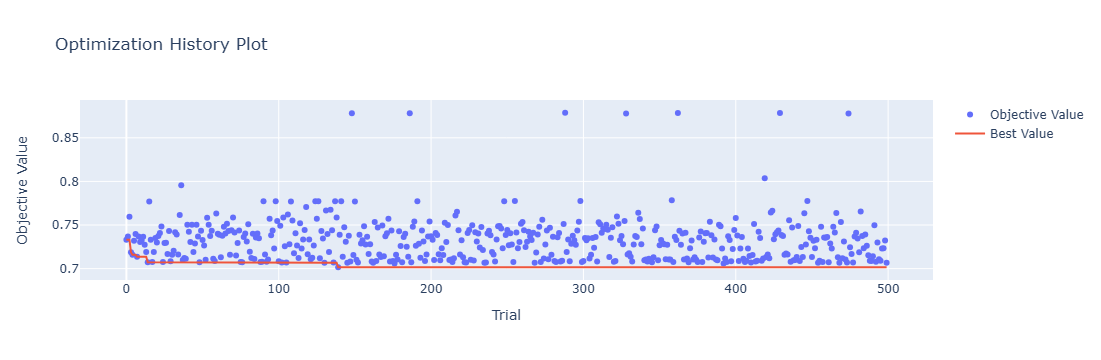

In [105]:
optuna.visualization.plot_optimization_history(study_opt_sbss_bc)

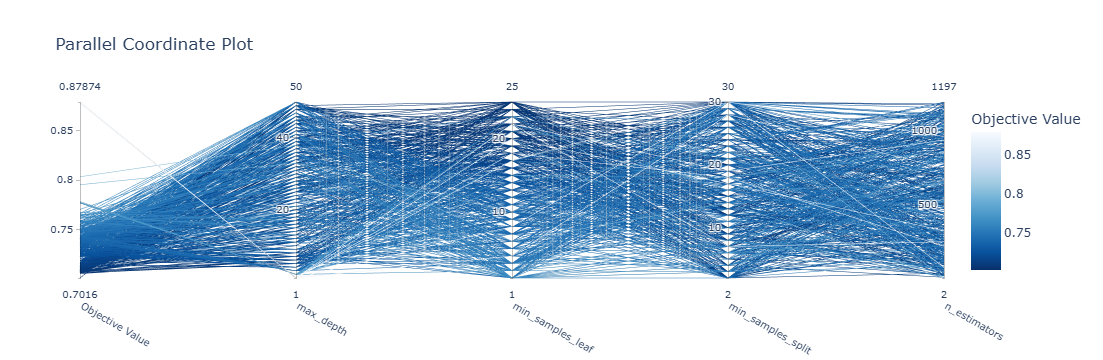

In [106]:
optuna.visualization.plot_parallel_coordinate(study_opt_sbss_bc)

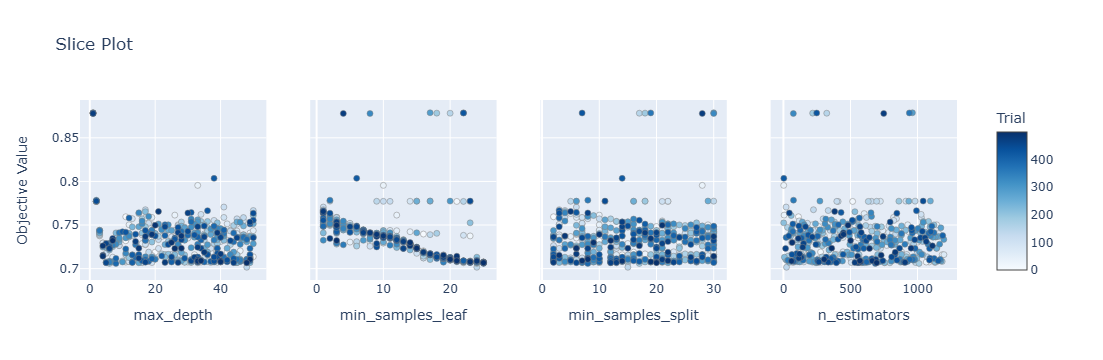

In [107]:
optuna.visualization.plot_slice(study_opt_sbss_bc, params = ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf' ])

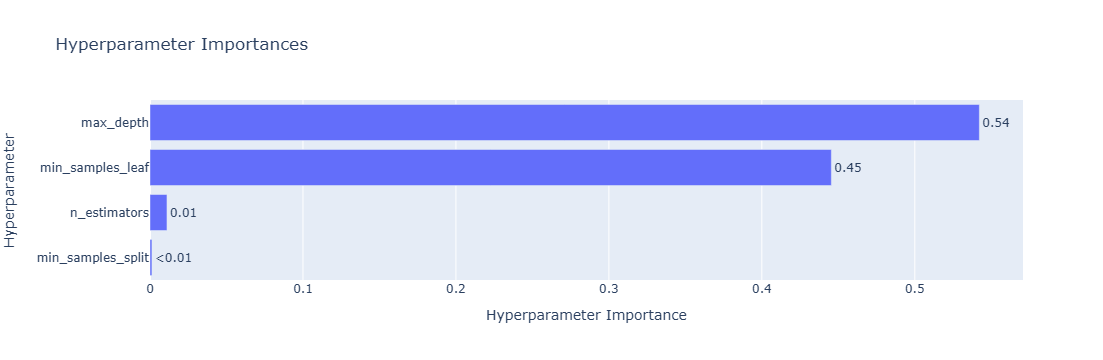

In [108]:
optuna.visualization.plot_param_importances(study_opt_sbss_bc)

In [109]:
with open('study_opt_sbss_bc', 'wb') as file:
         pickle.dump(study_opt_sbss_bc, file)

In [110]:
with open('SBSS_llocv_best_params', 'wb') as file:
         pickle.dump(best_params_SBSS, file)

In [111]:
# with open("SBSS_llocv_best_params","rb") as file:
#     best_params_SBSS = pickle.load(file)

In [112]:
# Train and Test the best model

best_n_estimators_opt_merged_sbss = best_params_SBSS['n_estimators']
best_max_depth_opt_merged_sbss = best_params_SBSS['max_depth']
best_min_samples_split_opt_merged_sbss = best_params_SBSS['min_samples_split']
best_min_samples_leaf_opt_merged_sbss = best_params_SBSS['min_samples_leaf']

best_model_opt_merged_sbss = RandomForestRegressor(n_estimators = best_n_estimators_opt_merged_sbss, max_depth = best_max_depth_opt_merged_sbss , 
                                              min_samples_split= best_min_samples_split_opt_merged_sbss, 
                                              min_samples_leaf=best_min_samples_leaf_opt_merged_sbss, random_state=42, n_jobs = 3)

best_model_opt_merged_sbss.fit(X_train_sbss, y_train_sbss)

y_pred_opt_merged_sbss = best_model_opt_merged_sbss.predict(X_test_sbss)

rmse_model_opt_merged_sbss = np.sqrt(mean_squared_error(y_test_sbss_og, inv_boxcox(y_pred_opt_merged_sbss, lambda_boxcox)))
r2_model_opt_merged_sbss = r2_score(y_test_sbss, y_pred_opt_merged_sbss)
r2_model_opt_merged_sbss_og = r2_score(y_test_sbss_og, inv_boxcox(y_pred_opt_merged_sbss, lambda_boxcox))
r_model_opt_merged_sbss = pearson_corr_coeff(y_test_sbss, y_pred_opt_merged_sbss)

print('RMSE [mg/L], model = opt merged _sbss: ',rmse_model_opt_merged_sbss)
print('R2, model = opt merged _sbss: ', r2_model_opt_merged_sbss)
print('R2 OG, model = opt merged _sbss: ', r2_model_opt_merged_sbss_og)
print('R, model = opt merged _sbss: ', r_model_opt_merged_sbss)

RMSE [mg/L], model = opt merged _sbss:  1.4632497076312798
R2, model = opt merged _sbss:  0.5000441227229153
R2 OG, model = opt merged _sbss:  0.49150699278783827
R, model = opt merged _sbss:  0.7342964031199767


In [113]:
y_pred_opt_merged_sbss

array([ 2.12122576,  1.8136216 ,  1.41448555, ...,  1.93489437,
        2.83762152, -0.33268135])

In [114]:
y_pred_opt_merged_sbss_og = inv_boxcox(y_pred_opt_merged_sbss, lambda_boxcox)

In [115]:
# Calculate the goodness of fit for monthly subsets
# extract the datafame for just the test indices
# extract the indices where the month is equal to the given month
# extract the y_test and y_pred values at these indices and compute gof

df_test_sbss = merged_dfs_scaled.iloc[test_indices_sbss,:].reset_index(drop = True)  # Extract all the data in the test set dataframe and reset its index to match the indexy range of y_predict
y_test_reset_ind_sbss_og = y_test_sbss_og.reset_index(drop = True)    # y_test had row indices of the original dataframe. Reset index to match index of y_predict
y_test_reset_ind_sbss = y_test_sbss.reset_index(drop = True)
df_train_sbss = merged_dfs_scaled.iloc[train_indices_sbss,:].reset_index(drop = True)
# save the data in a dictionary. keys are the month names. These dicts will later be used to generate figures.
rmse_Months_opt_merged_sbss = {}
r2_Months_opt_merged_sbss_og = {}
r2_Months_opt_merged_sbss = {}
r_Months_opt_merged_sbss = {}
y_pred_Months_opt_merged_sbss = {}
y_test_Months_opt_merged_sbss = {}

y_pred_Months_opt_merged_sbss_og = {}
y_test_Months_opt_merged_sbss_og = {}


df_months_test_sbss = {}
df_months_train_sbss = {}

for i, month in enumerate(months):
                         
    df_test_month = df_test_sbss.loc[df_test_sbss['month'] == (i+1),:]   # Extract the data from test set corresponding to the given month
    df_train_month = df_train_sbss.loc[df_train_sbss['month'] == (i+1),:]
    df_test_month_indices = df_test_month.index                # Extract the indices from the test set that correspond to the given month
    # only calculate the error metrics for a subset of the test set. Subset based on the given month. 
    y_test_month_og = y_test_reset_ind_sbss_og[df_test_month_indices]
    y_pred_month_og = y_pred_opt_merged_sbss_og[df_test_month_indices]

    y_test_month = y_test_reset_ind_sbss[df_test_month_indices]
    y_pred_month = y_pred_opt_merged_sbss[df_test_month_indices]    
    
    
    rmse_month_opt_merged = np.sqrt(mean_squared_error(y_test_month_og, y_pred_month_og))
    r2_month_opt_merged = r2_score(y_test_month, y_pred_month)
    r2_month_opt_merged_og = r2_score(y_test_month_og, y_pred_month_og)
    r_month_opt_merged = pearson_corr_coeff(y_test_month, y_pred_month)

    # add data to the dictionaries
    rmse_Months_opt_merged_sbss[month] = rmse_month_opt_merged
    r2_Months_opt_merged_sbss[month] = r2_month_opt_merged
    r2_Months_opt_merged_sbss_og[month] = r2_month_opt_merged_og
    r_Months_opt_merged_sbss[month] = r_month_opt_merged
    
    y_pred_Months_opt_merged_sbss[month] = y_pred_month
    y_test_Months_opt_merged_sbss[month] = y_test_month

    y_pred_Months_opt_merged_sbss_og[month] = y_pred_month_og
    y_test_Months_opt_merged_sbss_og[month] = y_test_month_og
    
    df_months_test_sbss[month] = df_test_month
    df_months_train_sbss[month] = df_train_month
    # print gof metrics for each month
    print(f'RMSE opt for {month} = {np.round(rmse_Months_opt_merged_sbss[month],5)}')
    print(f'R2 opt for {month} = {np.round(r2_Months_opt_merged_sbss[month],5)}')
    print(f'R2 OG opt for {month} = {np.round(r2_Months_opt_merged_sbss_og[month],5)}')
    print(f'R opt for {month} = {np.round(r_Months_opt_merged_sbss[month], 5)}')
    print('')

RMSE opt for jan = 1.48573
R2 opt for jan = 0.55911
R2 OG opt for jan = 0.55116
R opt for jan = 0.765

RMSE opt for feb = 1.42699
R2 opt for feb = 0.57477
R2 OG opt for feb = 0.5723
R opt for feb = 0.77541

RMSE opt for mar = 1.53095
R2 opt for mar = 0.55471
R2 OG opt for mar = 0.52646
R opt for mar = 0.76106

RMSE opt for apr = 1.51029
R2 opt for apr = 0.51483
R2 OG opt for apr = 0.4888
R opt for apr = 0.7359

RMSE opt for may = 1.43241
R2 opt for may = 0.4728
R2 OG opt for may = 0.43498
R opt for may = 0.72747

RMSE opt for jun = 1.42606
R2 opt for jun = 0.4842
R2 OG opt for jun = 0.46998
R opt for jun = 0.7313

RMSE opt for jul = 1.4363
R2 opt for jul = 0.36021
R2 OG opt for jul = 0.36604
R opt for jul = 0.69749

RMSE opt for aug = 1.44217
R2 opt for aug = 0.35709
R2 OG opt for aug = 0.35701
R opt for aug = 0.68257

RMSE opt for sep = 1.42529
R2 opt for sep = 0.46043
R2 OG opt for sep = 0.45712
R opt for sep = 0.71876

RMSE opt for oct = 1.40445
R2 opt for oct = 0.48028
R2 OG opt fo

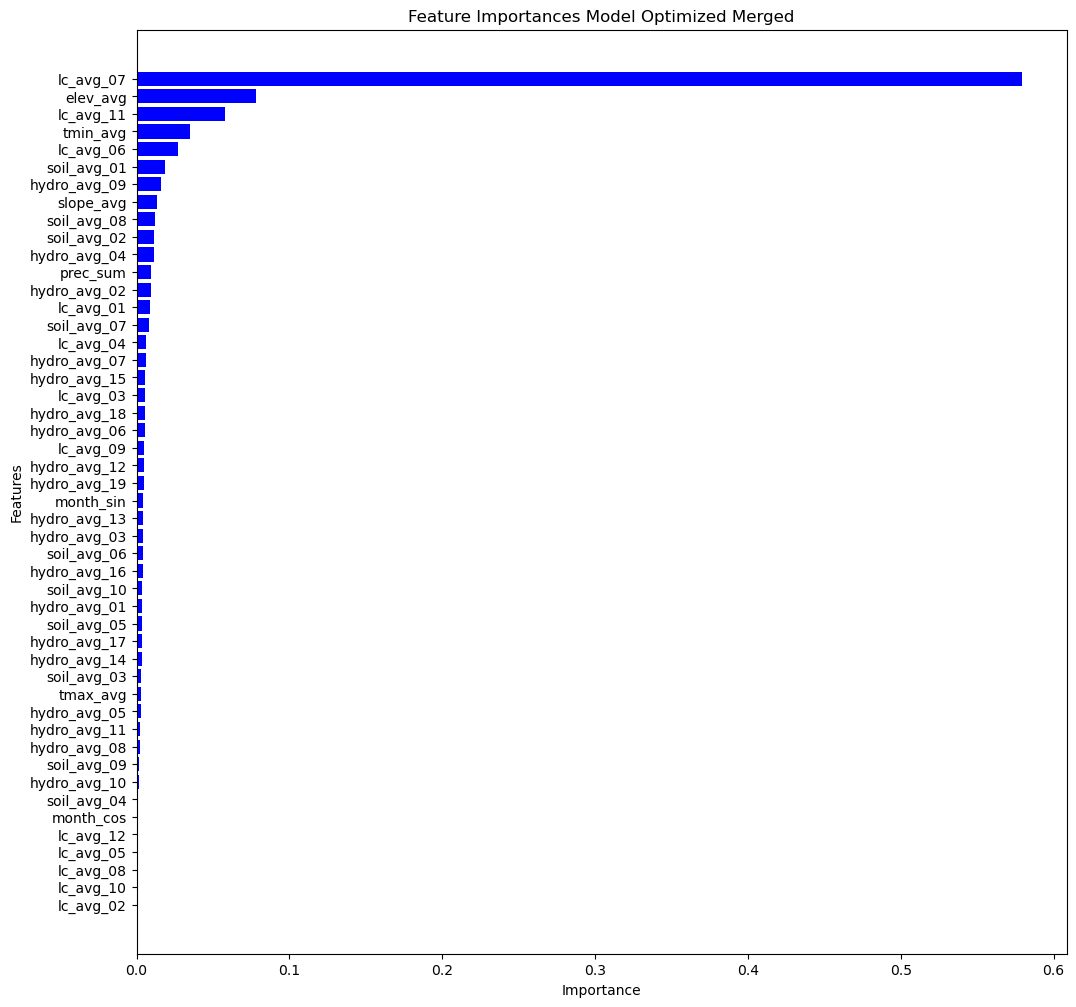

In [116]:
# Less features

feature_importances_sbss = best_model_opt_merged_sbss.feature_importances_

indices = np.argsort(feature_importances_sbss)

# Prepare the figure
plt.figure(figsize=(12, 12))
plt.title('Feature Importances Model Optimized Merged')

# Create horizontal bars
plt.barh(range(len(indices)), feature_importances_sbss[indices], color='b', align='center')

# Add feature names as y-tick labels
plt.yticks(range(len(indices)), [merged_dfs.columns[8:][i] for i in indices])

# Label the axes
plt.xlabel('Importance')
plt.ylabel('Features')
#plt.savefig('feature_importance_opt_merged.jpg', format = 'jpg', bbox_inches = 'tight')
# Show the plot
plt.show()

In [117]:
features_filtered = [merged_dfs_scaled.iloc[:,8:].columns[i] for i in range(len(feature_importances_sbss)) if feature_importances_sbss[i] > 0.01 ]

In [118]:
features_filtered

['slope_avg',
 'elev_avg',
 'lc_avg_06',
 'lc_avg_07',
 'lc_avg_11',
 'hydro_avg_04',
 'hydro_avg_09',
 'soil_avg_01',
 'soil_avg_02',
 'soil_avg_08',
 'tmin_avg']

In [127]:
vars2save = [merged_dfs, merged_dfs_scaled,
             station_names_train, station_names_test,
             X_train_sbss,
             X_test_sbss,
             y_train_sbss,
             y_test_sbss,
             y_train_sbss_og,
             y_test_sbss_og,
             train_indices_sbss,
             test_indices_sbss,
             y_pred_default_merged_sbss,
             y_pred_opt_merged_sbss,
             feature_importances_sbss,
             rmse_model_default_merged_sbss,
             r2_model_default_merged_sbss,
             r2_model_default_merged_sbss_og,
             rmse_model_opt_merged_sbss,
             r2_model_opt_merged_sbss,
             r2_model_opt_merged_sbss_og,
             rmse_Months_opt_merged_sbss,
             r2_Months_opt_merged_sbss]

vars_name = ['merged_dfs_sbss', 'merged_dfs_scaled_sbss',
             'station_names_train_sbss', 'station_names_test_sbss',
             'X_train_sbss',
             'X_test_sbss',
             'y_train_sbss',
             'y_test_sbss',
             'y_train_sbss_og',
             'y_test_sbss_og',
             'train_indices_sbss',
             'test_indices_sbss',
             'y_pred_default_merged_sbss',
             'y_pred_opt_merged_sbss',
             'feature_importances_sbss',
             'rmse_model_default_merged_sbss',
             'r2_model_default_merged_sbss',
             'r2_model_default_merged_sbss_og',
             'rmse_model_opt_merged_sbss',
             'r2_model_opt_merged_sbss',
             'r2_model_opt_merged_sbss_og',
             'rmse_Months_opt_merged_sbss',
             'r2_Months_opt_merged_sbss'] 


In [128]:
for i in range(len(vars2save)):
    # save the variables
    filepath = vars_name[i]
    with open(filepath, 'wb') as file:
        pickle.dump(vars2save[i], file)